(c) [Julius Hense](https://github.com/hense96) & [Mina Jamshidi](https://github.com/minajamshidi) @ TU Berlin, 2024

(c) This notebook is an asset of xMIL: https://github.com/tubml-pathology/xMIL

Please note the license and citation instructions as described in the above repository.

----

# Pipeline for visualizing precomputed heatmaps

In this notebook, we demonstrate how to visualize the pre-computed explanation scores. The explanation scores should be beforehand computed and saved using ```test.py```. At the end of the pipeline, you can generate overlay of the heatmap for potential use in softwares like QuPath.

If you did not run ```test.py``` for your slide, you can use the notebook ```slide_visualizations_computed_heatmaps```. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import json
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import openslide
import PIL

from visualization.slideshow import slide_heatmap_thumbnail, heatmap_PIL, plot_PIL
from visualization.utils import clean_outliers_fliers

## 1. Select and load a model of interest

In [4]:
# === SPECIFY === #

model_name = 'transmil'
proj_name = 'hnsc_hpv'

model_dir_root = '/path/to/results/trained_models'  # *** SPECIFY ======

model_dir = os.path.join(model_dir_root, proj_name, model_name)  # or specify your model directory directly here 


In [5]:
with open(os.path.join(model_dir, 'args.json')) as f:
    args = json.load(f)

slides_dirs = [patches_dir[:-11] + 'slides' for patches_dir in args['patches_dirs']]
annotation_dirs = [patches_dir[:-11] + 'annotations' for patches_dir in args['patches_dirs']
                   if os.path.isdir(patches_dir[:-11] + 'annotations')]
patches_dirs = args['patches_dirs']

print(slides_dirs)
print(annotation_dirs)
print(patches_dirs)

['/home/space/datasets/tcga/hnsc/slides']
[]
['/home/space/datasets/tcga/hnsc/patches/20x']


In [6]:
args

{'split_path': '/home/space/datasets/tcga/splits/tcga_hnsc_hpv_cv3_0.csv',
 'metadata_dirs': ['/home/space/datasets/tcga/hnsc/metadata/v001'],
 'patches_dirs': ['/home/space/datasets/tcga/hnsc/patches/20x'],
 'features_dirs': ['/home/space/datasets/tcga/hnsc/features/20x/ctranspath_pt'],
 'results_dir': '/home/juliush/results/xMIL/models/hopt_v3b/hnsc_hpv/transmil/fold_0/1',
 'model_param_path': None,
 'train_subsets': ['1', '2'],
 'val_subsets': ['0'],
 'test_subsets': ['0'],
 'balance_key': None,
 'sampler': None,
 'drop_duplicates': 'sample',
 'patch_filters': None,
 'train_bag_size': 2048,
 'max_bag_size': 24000,
 'preload_data': True,
 'aggregation_model': 'transmil',
 'input_dim': 768,
 'num_classes': 2,
 'targets': ['label'],
 'no_bias': False,
 'additive': False,
 'n_out_layers': 0,
 'features_dim': 256,
 'inner_attention_dim': 128,
 'dropout_strategy': 'features',
 'dropout': 0,
 'num_layers': 1,
 'num_features': 256,
 'dropout_att': 0.0,
 'dropout_class': 0.0,
 'dropout_feat'

## 2. Visualizing explanation heatmaps

### 2.1. Read the pre-computed explanation scores of a desired slide

In [7]:
results_dir = os.path.join(model_dir, 'explanations') # *** SPECIFY: path to the pre-computed explanation scores

res_df = pd.read_csv(os.path.join(results_dir, 'test_predictions.csv'), index_col=0)

In [8]:
sel_idx = 7  # *** SPECIFY: the index of slide to be visualized

# ==== or find the index of a desired slide ==== 
# slide_name = 'TCGA-BA-5559-01Z-00-DX1' # *** SPECIFY: the slide name
# sel_idx = res_df.loc[res_df['slide_id'] == slide_name].index[0]

source_idx = 0
slide_extension = 'svs'

In [9]:
# Extract prediction information
slide_name = res_df.loc[sel_idx, 'slide_id']
pred_score = res_df.loc[sel_idx, 'prediction_score']
label = res_df.loc[sel_idx, 'label']
if source_idx is None:
    source_idx = label
print(slide_name, label, pred_score)


TCGA-BA-5559-01Z-00-DX1 1 0.9214591979980468


### 2.2. Plotting the heatmap

#### Visualize the slide and its annotation

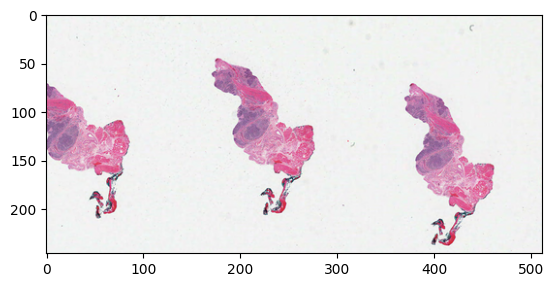

In [10]:
# Read slide, annotation, patch metadata
slide = openslide.open_slide(os.path.join(slides_dirs[source_idx], f'{slide_name}.{slide_extension}'))
if len(annotation_dirs) > 0:
    annotation = openslide.open_slide(os.path.join(annotation_dirs[source_idx], f"{slide_name}.png"))
else:
    annotation = None
patches_this_slide = pd.read_csv(os.path.join(patches_dirs[source_idx], slide_name, 'metadata/df.csv'), index_col=0)
slide_thumbnail = slide.get_thumbnail((512, 512))
if annotation is None:
    plt.imshow(slide_thumbnail)
else:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].imshow(slide_thumbnail)
    axs[1].imshow(annotation.get_thumbnail((512, 512)))


#### Visualize the heatmap of the desired explanation method

In [11]:
# =========== SPECIFY =============
sel_explanation = 'lrp'  # ***SPECIFY: could be perturbation_keep, lrp, gi, grad2


In [12]:
# read explanation scores

patch_ids = np.asarray(ast.literal_eval(res_df.loc[sel_idx, 'patch_ids']))
patch_ids = patch_ids[0] if len(patch_ids.shape) > 1 else patch_ids
patch_scores = np.asarray(ast.literal_eval(res_df.loc[sel_idx, 'patch_scores_' + sel_explanation]))
patch_scores = patch_scores[0] if len(patch_scores.shape) > 1 else patch_scores
if annotation is not None:
    patch_labels = patches_this_slide.copy().set_index('patch_id').loc[patch_ids]
    patch_labels = patch_labels['annotation_classes'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    patch_labels = np.asarray((patch_labels['2'] > 0.0).astype(int))
else:
    patch_labels = None
    
patch_scores_plot, _ = clean_outliers_fliers(patch_scores)

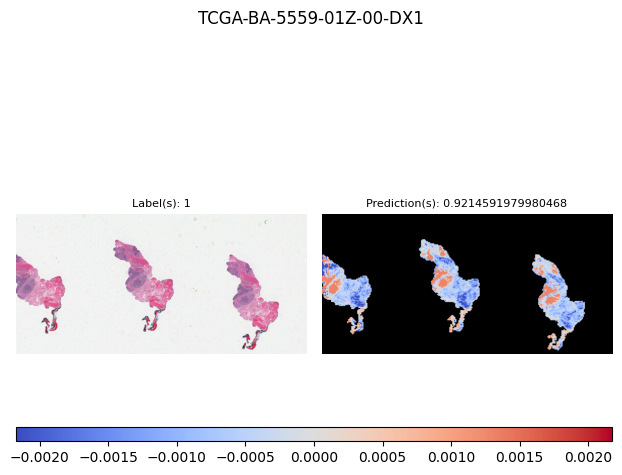

In [13]:
# Visualize patch scores in heatmap
cmap_name = 'coolwarm'
side_by_side = True
show_annotation = True
zero_centered = True

_ = slide_heatmap_thumbnail(
    slide, patches_this_slide, patch_ids, patch_scores_plot,
    slide_name=slide_name, label=str(label), pred_score=str(pred_score),
    annotation=(annotation if show_annotation else None), side_by_side=side_by_side,
    size=(2048, 2048), cmap_name=cmap_name, background='black', zero_centered=zero_centered)

### 2.3. Generating the overlay for QuPath

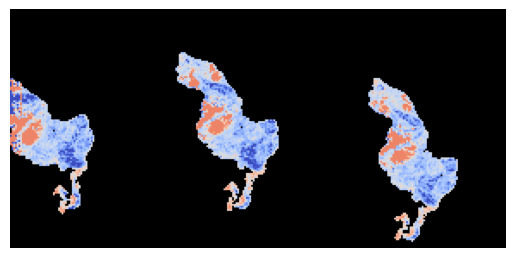

In [14]:
overlay_dims = (slide.dimensions[0] // 32, slide.dimensions[1] // 32)
heatmap, _ = heatmap_PIL(
    patches=patches_this_slide, size=overlay_dims, patch_ids=patch_ids, slide_dim=slide.dimensions, 
    score_values=patch_scores_plot, cmap_name=cmap_name, zero_centered=zero_centered)

fig = plt.figure()
ax = fig.add_subplot(111)

plot_PIL(ax, heatmap, cmap=cmap_name)

# heatmap.save(os.path.join(overlays_dir, f"{slide_name}_{sel_explanation}.png"), "PNG")


------